# Stress inversion of the Southern California focal mechanisms from SCEC:

Link: [https://scedc.caltech.edu/data/alt-2011-yang-hauksson-shearer.html](https://scedc.caltech.edu/data/alt-2011-yang-hauksson-shearer.html)

*References*

Yang, W., E. Hauksson and P. M. Shearer, Computing a large refined catalog of focal mechanisms for southern California (1981 - 2010): Temporal Stability of the Style of Faulting, Bull. Seismol. Soc. Am., June 2012, v. 102, p. 1179-1194, [doi:10.1785/0120110311](doi:10.1785/0120110311), 2012.

Hauksson E., W. Yang and P.M. Shearer, Waveform relocated earthquake catalog for southern California (1981 - 2011), Bull. Seismol. Soc. Am., Vol. 102, No. 5, October 2012, [doi:10.1785/0120120010](doi:10.1785/0120120010), 2012.

We focus the inversion on a region of limited extent: $33.60^{\mathrm{o}}\mathrm{N}-34.10^{\mathrm{o}}\mathrm{N}$ and $116.60^{\mathrm{o}}\mathrm{W}-117.00^{\mathrm{o}}\mathrm{W}$.

You may have to install `mplstereonet` [https://github.com/joferkington/mplstereonet](https://github.com/joferkington/mplstereonet), and `colorcet` [https://colorcet.holoviz.org/](https://colorcet.holoviz.org/).

In [48]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

import cartopy as ctp
import colorcet as cc
from obspy.imaging import beachball as obb

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely import geometry

import geopandas as geopd
import mplstereonet as mpl

import ILSI

from time import time as give_time

# plot data in Kaverina diagram
sys.path.append(
    os.path.join(
        "/home/eric/software/FMC/"
    )
)
import plotFMC
import functionsFMC
from functionsFMC import kave, mecclass

# set plotting parameters
import seaborn as sns

sns.set(font_scale=1.3)
sns.set_style("ticks")
sns.set_palette("colorblind")
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["svg.fonttype"] = "none"

# define the color palette
_colors_ = ["C0", "C2", "C1", "C4"]


In [49]:
# %config InlineBackend.figure_formats = ["svg"]

In [50]:
# path variables
data_path = "../data"
dataset_fn = "SoCal_dataset.csv"
# program parameter(s)
save_figures = False
# load dataset
data = pd.read_csv(os.path.join(data_path, dataset_fn), sep="\t", header=0, index_col=0)
data


,year,month,day,hour,minute,second,CID,mag,lat,lon,depth,strike,dip,rake,fp_unc,ap_unc,misfit
7,2011,1,1,2,55,40.10,10865461,1.64,33.67567,-116.72250,15.20,327,35,176,12,12,0.07
42,2011,1,3,3,50,17.81,10866517,1.62,33.63833,-116.69733,13.51,319,67,153,15,19,0.00
87,2011,1,7,0,16,44.86,10868757,1.24,33.62600,-116.74033,15.65,285,30,145,15,20,0.07
263,2011,1,19,14,9,2.04,10876357,1.09,33.62883,-116.76100,15.57,306,27,159,23,25,0.15
463,2011,2,2,17,15,26.49,14927556,2.86,33.64433,-116.71800,14.59,305,65,157,25,23,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13773,2013,12,28,12,7,6.65,11406842,1.55,33.71300,-116.75800,16.66,296,43,-177,15,21,0.13
13777,2013,12,29,15,30,29.10,11407178,1.61,33.65400,-116.71600,15.80,126,87,168,11,15,0.08
13788,2013,12,30,23,44,21.07,11407682,3.63,33.70950,-116.72950,18.12,144,54,-150,18,15,0.11
13791,2013,12,31,1,59,25.67,11407746,1.70,33.63400,-116.72150,16.79,3,23,170,19,12,0.02


## Plot data set

In [51]:
def add_scale_bar(ax, x_start, y_start, distance, source_crs, azimuth=90.0, **kwargs):
    """
    Parameters
    -----------
    ax: GeoAxes instance
        The axis on which we want to add a scale bar.
    x_start: float
        The x coordinate of the left end of the scale bar,
        given in the axis coordinate system, i.e. from 0 to 1.
    y_start: float
        The y coordinate of the left end of the scale bar,
        given in the axis coordinate system, i.e. from 0 to 1.
    distance: float
        The distance covered by the scale bar, in km.
    source_crs: cartopy.crs
        The coordinate system in which the data are written.
    """
    from cartopy.geodesic import Geodesic

    G = Geodesic()

    # default values
    kwargs["lw"] = kwargs.get("lw", 2)
    kwargs["color"] = kwargs.get("color", "k")

    data_coords = ctp.crs.PlateCarree()
    # transform the axis coordinates into display coordinates
    display = ax.transAxes.transform([x_start, y_start])
    # take display coordinates into data coordinates
    data = ax.transData.inverted().transform(display)
    # take data coordinates into lon/lat
    lon_start, lat_start = data_coords.transform_point(data[0], data[1], source_crs)
    # get the coordinates of the end of the scale bar
    lon_end, lat_end, _ = np.asarray(
        G.direct([lon_start, lat_start], azimuth, 1000.0 * distance)
    )[0]
    if azimuth % 180.0 == 90.0:
        lat_end = lat_start
    elif azimuth % 180.0 == 0.0:
        lon_end == lon_start
    ax.plot([lon_start, lon_end], [lat_start, lat_end], transform=data_coords, **kwargs)
    ax.text(
        (lon_start + lon_end) / 2.0,
        (lat_start + lat_end) / 2.0 - 0.001,
        "{:.0f}km".format(distance),
        transform=data_coords,
        ha="center",
        va="top",
    )
    return


def plot_Kaverina(strikes, dips, rakes, ax=None):
    n_earthquakes = len(strikes)
    # determine the t and p axes
    P_axis = np.zeros((n_earthquakes, 2), dtype=np.float32)
    T_axis = np.zeros((n_earthquakes, 2), dtype=np.float32)
    B_axis = np.zeros((n_earthquakes, 2), dtype=np.float32)
    faulting_type = np.zeros(n_earthquakes, dtype=np.int32)
    fm_type = []
    r2d = 180.0 / np.pi
    for t in range(n_earthquakes):
        # first, get normal and slip vectors from
        # strike, dip, rake
        normal, slip = ILSI.utils_stress.normal_slip_vectors(
            strikes[t], dips[t], rakes[t]
        )
        # second, get the t and p vectors
        p_axis, t_axis, b_axis = ILSI.utils_stress.p_t_b_axes(normal, slip)
        p_bearing, p_plunge = ILSI.utils_stress.get_bearing_plunge(p_axis)
        t_bearing, t_plunge = ILSI.utils_stress.get_bearing_plunge(t_axis)
        b_bearing, b_plunge = ILSI.utils_stress.get_bearing_plunge(b_axis)
        P_axis[t, :] = p_bearing, p_plunge
        T_axis[t, :] = t_bearing, t_plunge
        B_axis[t, :] = b_bearing, b_plunge
        fm_type.append(mecclass(t_plunge, b_plunge, p_plunge))
    # get the x, y coordinates for FMC's plots
    x_kave, y_kave = kave(T_axis[:, 1], B_axis[:, 1], P_axis[:, 1])

    colors_fm = {}
    colors_fm["SS"] = "C0"
    colors_fm["SS-N"] = "C0"
    colors_fm["SS-R"] = "C0"
    colors_fm["R"] = "C1"
    colors_fm["R-SS"] = "C1"
    colors_fm["N"] = "C2"
    colors_fm["N-SS"] = "C2"
    colors = np.asarray([colors_fm[fm] for fm in fm_type])

    if ax is None:
        fig = plt.figure("Kaverina_diagram", figsize=(12, 12))
        ax = fig.add_subplot(111)
    fig = plotFMC.baseplot(10, "", ax=ax)
    ax.scatter(x_kave, y_kave, color=colors)
    return fig


In [52]:
# define region extent
lat_min_box, lat_max_box = 33.57, 33.76
lon_min_box, lon_max_box = -116.85, -116.60
# define inset extent
lat_min_inset, lat_max_inset = 31.00, 37.00
lon_min_inset, lon_max_inset = -120.00, -111.00
# define depth color map
cNorm_box = Normalize(
    vmin=np.floor(data["depth"].min()), vmax=np.ceil(data["depth"].max())
)
scalar_map_box = ScalarMappable(norm=cNorm_box, cmap=cc.cm.fire_r)
# define projections
data_coords = ctp.crs.PlateCarree()
projection = ctp.crs.Mercator(
    central_longitude=(lon_min_box + lon_max_box) / 2.0,
    min_latitude=lat_min_box,
    max_latitude=lat_max_box,
)
projection_inset = ctp.crs.Mercator(
    central_longitude=(lon_min_inset + lon_max_inset) / 2.0,
    min_latitude=lat_min_inset,
    max_latitude=lat_max_inset,
)


/home/eric/miniconda3/envs/py310/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


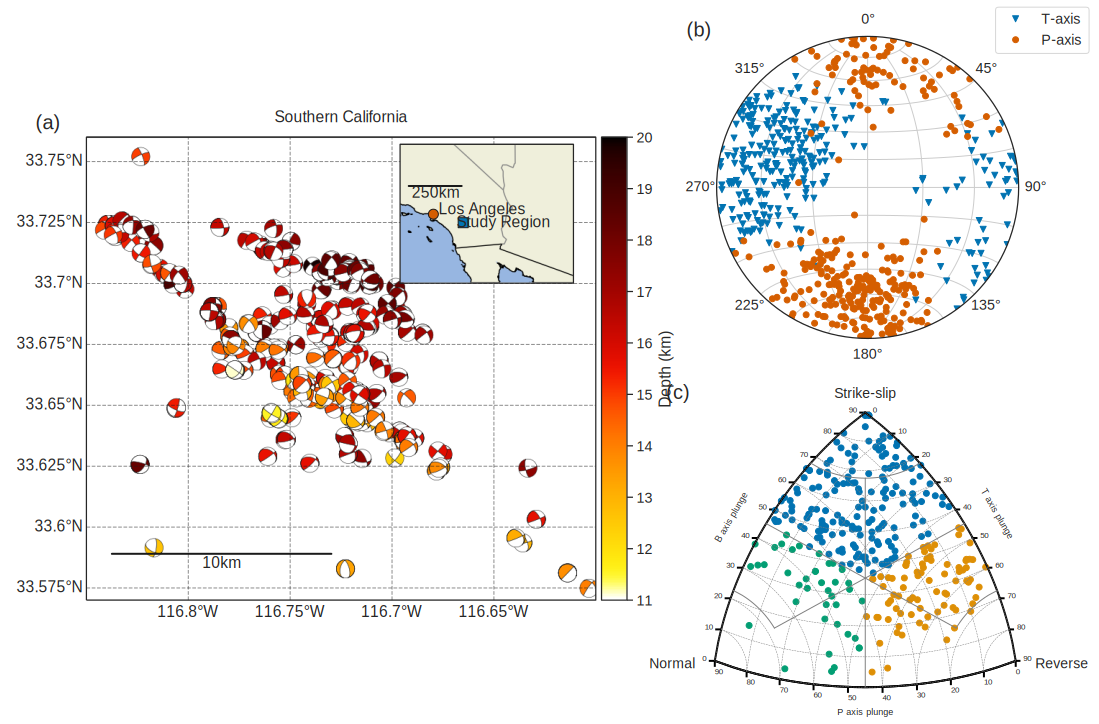

In [53]:
# plot the focal mechanisms
fig_fm = plt.figure("earthquakes_SoCal", figsize=(15, 12))
gs = fig_fm.add_gridspec(2, 5)
ax_fm = fig_fm.add_subplot(gs[:, :3], projection=projection)
ax_fm.set_rasterization_zorder(1.5)
ax_fm.set_extent([lon_min_box, lon_max_box, lat_min_box, lat_max_box], crs=data_coords)
ax_fm.set_title("Southern California", pad=15)

# plot inset map
axins = inset_axes(
    ax_fm,
    width="40%",
    height="30%",
    loc="upper right",
    axes_class=ctp.mpl.geoaxes.GeoAxes,
    axes_kwargs=dict(map_projection=projection_inset),
)
axins.set_rasterization_zorder(1.5)
axins.set_extent(
    [lon_min_inset, lon_max_inset, lat_min_inset, lat_max_inset], crs=data_coords
)
study_region = geometry.box(
    minx=lon_min_box, maxx=lon_max_box, miny=lat_min_box, maxy=lat_max_box
)
# axins.add_geometries([study_region], crs=data_coords, edgecolor='k', facecolor='C0')
axins.plot(
    (lon_min_box + lon_max_box) / 2.0,
    (lat_min_box + lat_max_box) / 2.0,
    marker="s",
    color="C0",
    markersize=10,
    markeredgecolor="k",
    transform=data_coords,
)
axins.text(
    (lon_min_box + lon_max_box) / 2.0 - 0.35,
    (lat_min_box + lat_max_box) / 2.0 - 0.20,
    "Study Region",
    transform=data_coords,
)
# plot Los Angeles
axins.plot(
    -118.271690,
    34.034956,
    marker="o",
    color="C3",
    markersize=10,
    markeredgecolor="k",
    transform=data_coords,
)
axins.text(-118.00, 34.034956, "Los Angeles", transform=data_coords)

for ax in [axins, ax_fm]:
    ax.add_feature(
        ctp.feature.NaturalEarthFeature(
            "cultural",
            "admin_1_states_provinces_lines",
            "110m",
            edgecolor="gray",
            facecolor="none",
        )
    )
    ax.add_feature(ctp.feature.BORDERS)
    ax.add_feature(ctp.feature.GSHHSFeature(scale="full", levels=[1], zorder=0.49))
    # ax.add_geometries(faults['geometry'], crs=data_coords,
    #                  facecolor='none', edgecolor='k')

axins.add_feature(ctp.feature.LAND)
axins.add_feature(ctp.feature.OCEAN)
add_scale_bar(axins, 0.05, 0.70, 250.0, projection_inset)

# add meridians and latitudes
gl = ax_fm.gridlines(
    draw_labels=True, linewidth=1, alpha=0.5, color="k", linestyle="--"
)
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True
for i in range(len(data)):
    # fetch focal mechanism
    strike, dip, rake = (
        data.iloc[i]["strike"],
        data.iloc[i]["dip"],
        data.iloc[i]["rake"],
    )
    # determine coordinates in the axis frame of reference
    x, y = ax_fm.projection.transform_point(
        data.iloc[i]["lon"], data.iloc[i]["lat"], data_coords
    )
    fc = scalar_map_box.to_rgba(data.iloc[i]["depth"])
    # ---------------------------
    # uncomment if you are not planning on saving svg figures:
    # bb = obb.beach(
    #    [strike, dip, rake], xy=(x, y), width=20,
    #    facecolor=fc, linewidth=0.4, axes=ax_fm)
    # ---------------------------
    # uncomment if you are planning on making svg figures
    bb = obb.beach(
        [strike, dip, rake],
        xy=(x, y),
        width=1000,
        facecolor=fc,
        linewidth=0.4,
        zorder=1.4,
    )
    # ---------------------------
    ax_fm.add_collection(bb)
# add colorbar
divider = make_axes_locatable(ax_fm)
cax = divider.append_axes("right", size="5%", pad=0.08, axes_class=plt.Axes)
plt.colorbar(scalar_map_box, cax=cax, label="Depth (km)", orientation="vertical")
# add scale bar
add_scale_bar(ax_fm, 0.05, 0.1, 10.0, projection)
# ---------------------------------------------------
#        plot data points in P/T space
ax_pt = fig_fm.add_subplot(gs[0, 3:], projection="stereonet")
# ax_pt.set_title('Stereographic projection of P/T axes', pad=50)
# fetch focal mechanisms
strikes, dips, rakes = data["strike"], data["dip"], data["rake"]
n, s = ILSI.utils_stress.normal_slip_vectors(strikes, dips, rakes)
# compute the bearing and plunge of each P/T vector
p_or = np.zeros((len(strikes), 2), dtype=np.float32)
t_or = np.zeros((len(strikes), 2), dtype=np.float32)
for i in range(len(strikes)):
    p, t, b = ILSI.utils_stress.p_t_b_axes(n[:, i], s[:, i])
    p_or[i, :] = ILSI.utils_stress.get_bearing_plunge(p)
    t_or[i, :] = ILSI.utils_stress.get_bearing_plunge(t)
ax_pt.line(t_or[:, 1], t_or[:, 0], marker="v", color="C0")
ax_pt.line(p_or[:, 1], p_or[:, 0], marker="o", color="C3")
ax_pt.line(t_or[0, 1], t_or[0, 0], marker="v", color="C0", label="T-axis")
ax_pt.line(p_or[0, 1], p_or[0, 0], marker="o", color="C3", label="P-axis")
ax_pt.grid(True)
ax_pt.legend(loc="lower left", bbox_to_anchor=(0.90, 0.92))
# ---------------------------------------------------
#            plot data points in Kaverina diagram
ax_Kav = fig_fm.add_subplot(gs[1, 3:])
fig_fm = plot_Kaverina(strikes.values, dips.values, rakes.values, ax=ax_Kav)
for i, ax in enumerate([ax_fm, ax_pt, ax_Kav]):
    ax.text(
        -0.1,
        1.05,
        f"({string.ascii_lowercase[i]})",
        va="top",
        fontsize=20,
        ha="left",
        transform=ax.transAxes,
    )
plt.subplots_adjust(wspace=0.55, left=0.1, right=0.98)

ax_pt._polar.set_position(ax_pt.get_position())


In [54]:
if save_figures:
    fig_fm.savefig(f'{fig_fm._label}.svg', format='svg', bbox_inches='tight')

## Stress tensor inversion

In [55]:
# --------------------------------
# prepare data
# --------------------------------
strikes, dips, rakes = data["strike"], data["dip"], data["rake"]
strikes_1, dips_1, rakes_1 = strikes.values, dips.values, rakes.values
rakes_1 = np.float32(rakes_1) % 360.0
n_earthquakes = len(strikes_1)
strikes_2, dips_2, rakes_2 = np.asarray(
    list(map(ILSI.utils_stress.aux_plane, strikes_1, dips_1, rakes_1))
).T


In [56]:
# --------------------------------
# inversion parameters
# --------------------------------
# if you want to search for the "best" friction coefficient, set friction_coefficient to None
friction_min = 0.1
friction_max = 1.0
friction_step = 0.05
# if you want to fix the friction coefficient to some value, set friction_coefficient equal to that value
# (the paper uses a fixed friction_coefficient = 0.6)
friction_coefficient = 0.6
n_random_selections = 30
n_stress_iter = 10
n_resamplings = 2000
n_averaging = 3
# parallelization option: use n_threads="all" if you want to use all your CPUs to speed up the computation
#                         use n_threads=X with X any integer number to use a specific number of CPUs
n_threads = "all"
ILSI_kwargs = {}
ILSI_kwargs["max_n_iterations"] = 300
ILSI_kwargs["shear_update_atol"] = 1.0e-5
Tarantola_kwargs = {}


In [57]:
# --------------------------------
# initialize output dictionary
# --------------------------------
inversion_output = {}
methods = ["linear", "iterative_constant_shear", "iterative_variable_shear"]
for method in methods:
    inversion_output[method] = {}


In [58]:
# --------------------------------
# invert the whole dataset
# --------------------------------
print(f"Linear inversion...")
# simple, linear inversion
inversion_output["linear"] = ILSI.ilsi.inversion_one_set(
    strikes_1,
    dips_1,
    rakes_1,
    n_random_selections=n_random_selections,
    **ILSI_kwargs,
    Tarantola_kwargs=Tarantola_kwargs,
    variable_shear=False,
    return_stats=True,
)
print(f"Iterative constant shear inversion...")
inversion_output["iterative_constant_shear"] = ILSI.ilsi.inversion_one_set_instability(
    strikes_1,
    dips_1,
    rakes_1,
    n_random_selections=n_random_selections,
    **ILSI_kwargs,
    Tarantola_kwargs=Tarantola_kwargs,
    friction_min=friction_min,
    friction_max=friction_max,
    friction_step=friction_step,
    friction_coefficient=friction_coefficient,
    n_stress_iter=n_stress_iter,
    n_averaging=n_averaging,
    variable_shear=False,
    signed_instability=False,
    return_stats=True,
)
if friction_coefficient is None:
    print(
        f'Inverted friction: {inversion_output["iterative_constant_shear"]["friction_coefficient"]:.2f}'
    )
print(f"Iterative variable shear inversion...")
inversion_output["iterative_variable_shear"] = ILSI.ilsi.inversion_one_set_instability(
    strikes_1,
    dips_1,
    rakes_1,
    n_random_selections=n_random_selections,
    **ILSI_kwargs,
    Tarantola_kwargs=Tarantola_kwargs,
    friction_min=friction_min,
    friction_max=friction_max,
    friction_step=friction_step,
    friction_coefficient=friction_coefficient,
    n_stress_iter=n_stress_iter,
    n_averaging=n_averaging,
    variable_shear=True,
    signed_instability=False,
    return_stats=True,
    plot=False,
)
if friction_coefficient is None:
    print(
        f'Inverted friction: {inversion_output["iterative_variable_shear"]["friction"]:.2f}'
    )
for method in methods:
    R = ILSI.utils_stress.R_(inversion_output[method]["principal_stresses"])
    I, fp_strikes, fp_dips, fp_rakes = ILSI.ilsi.compute_instability_parameter(
        inversion_output[method]["principal_directions"],
        R,
        inversion_output[method]["friction_coefficient"] if "friction_coefficient" in inversion_output[method] else 0.6,
        strikes_1,
        dips_1,
        rakes_1,
        strikes_2,
        dips_2,
        rakes_2,
        return_fault_planes=True,
    )
    inversion_output[method]["misfit"] = np.mean(
        ILSI.utils_stress.mean_angular_residual(
            inversion_output[method]["stress_tensor"], fp_strikes, fp_dips, fp_rakes
        )
    )


Linear inversion...
Iterative constant shear inversion...
-------- 1/3 ----------
Initial shape ratio: 0.52
-------- 2/3 ----------
Initial shape ratio: 0.52
-------- 3/3 ----------
Initial shape ratio: 0.51
Final results:
Stress tensor:
 [[-0.6716555   0.22080024 -0.30328417]
 [ 0.22080024  0.46953318 -0.05513182]
 [-0.30328417 -0.05513182  0.20212229]]
Shape ratio: 0.77
Iterative variable shear inversion...
-------- 1/3 ----------
Initial shape ratio: 0.52
-------- 2/3 ----------
Initial shape ratio: 0.52
-------- 3/3 ----------
Initial shape ratio: 0.51
Final results:
Stress tensor:
 [[-0.63369316  0.18224983 -0.3860853 ]
 [ 0.18224983  0.4447647  -0.01297786]
 [-0.3860853  -0.01297786  0.18892848]]
Shape ratio: 0.85


In [59]:
# --------------------------------
# bootstrap the dataset to infer uncertainties
# --------------------------------
print(f"Linear inversion (bootstrapping)...")
t1 = give_time()
# simple, linear inversion
bootstrap = ILSI.ilsi.inversion_bootstrap(
    strikes_1,
    dips_1,
    rakes_1,
    n_resamplings=n_resamplings,
    Tarantola_kwargs=Tarantola_kwargs,
    variable_shear=False,
)
for field in bootstrap:
    inversion_output["linear"][field] = bootstrap[field]
t2 = give_time()
print(f"Done in {t2-t1:.2f}sec!")
t1 = give_time()
print(f"Iterative constant shear inversion (bootstrapping)...")
bootstrap = ILSI.ilsi.inversion_bootstrap_instability(
    inversion_output["iterative_constant_shear"]["principal_directions"],
    ILSI.utils_stress.R_(
        inversion_output["iterative_constant_shear"]["principal_stresses"]
    ),
    strikes_1,
    dips_1,
    rakes_1,
    inversion_output["iterative_constant_shear"]["friction_coefficient"],
    **ILSI_kwargs,
    Tarantola_kwargs=Tarantola_kwargs,
    n_stress_iter=n_stress_iter,
    n_resamplings=n_resamplings,
    n_threads=n_threads,
    variable_shear=False,
    signed_instability=False,
)
for field in bootstrap:
    inversion_output["iterative_constant_shear"][field] = bootstrap[field]

t2 = give_time()
print(f"Done in {t2-t1:.2f}sec!")
t1 = give_time()
print(f"Iterative variable shear inversion (bootstrapping)...")
bootstrap = ILSI.ilsi.inversion_bootstrap_instability(
    inversion_output["iterative_variable_shear"]["principal_directions"],
    ILSI.utils_stress.R_(
        inversion_output["iterative_variable_shear"]["principal_stresses"]
    ),
    strikes_1,
    dips_1,
    rakes_1,
    inversion_output["iterative_variable_shear"]["friction_coefficient"],
    **ILSI_kwargs,
    Tarantola_kwargs=Tarantola_kwargs,
    n_stress_iter=n_stress_iter,
    n_resamplings=n_resamplings,
    n_threads=n_threads,
    variable_shear=True,
    signed_instability=False,
)
for field in bootstrap:
    inversion_output["iterative_variable_shear"][field] = bootstrap[field]
t2 = give_time()
print(f"Done in {t2-t1:.2f}sec!")


Linear inversion (bootstrapping)...
---------- Bootstrapping 1/2000 ----------
---------- Bootstrapping 101/2000 ----------
---------- Bootstrapping 201/2000 ----------
---------- Bootstrapping 301/2000 ----------
---------- Bootstrapping 401/2000 ----------
---------- Bootstrapping 501/2000 ----------
---------- Bootstrapping 601/2000 ----------
---------- Bootstrapping 701/2000 ----------
---------- Bootstrapping 801/2000 ----------
---------- Bootstrapping 901/2000 ----------
---------- Bootstrapping 1001/2000 ----------
---------- Bootstrapping 1101/2000 ----------
---------- Bootstrapping 1201/2000 ----------
---------- Bootstrapping 1301/2000 ----------
---------- Bootstrapping 1401/2000 ----------
---------- Bootstrapping 1501/2000 ----------
---------- Bootstrapping 1601/2000 ----------
---------- Bootstrapping 1701/2000 ----------
---------- Bootstrapping 1801/2000 ----------
---------- Bootstrapping 1901/2000 ----------
Done in 25.97sec!
Iterative constant shear inversion (bo

In [60]:
inversion_output["strikes"] = np.stack((strikes_1, strikes_2), axis=1)
inversion_output["dips"] = np.stack((dips_1, dips_2), axis=1)
inversion_output["rakes"] = np.stack((rakes_1, rakes_2), axis=1)


In [61]:
def plot_inverted_stress_tensors(inversion_output, axes=None, figtitle="", **kwargs):
    hist_kwargs = {}
    hist_kwargs["smoothing_sig"] = kwargs.get("smoothing_sig", 1)
    hist_kwargs["nbins"] = kwargs.get("nbins", 200)
    hist_kwargs["return_count"] = kwargs.get("return_count", True)
    hist_kwargs["confidence_intervals"] = kwargs.get("confidence_intervals", [95.0])
    markers = ["o", "s", "v"]
    methods = ["linear", "iterative_constant_shear", "iterative_variable_shear"]
    n_resamplings = inversion_output["linear"]["boot_principal_directions"].shape[0]
    fig = plt.figure("inverted_stress_tensors_SoCal", figsize=(15, 9))
    fig.suptitle(figtitle)
    gs = fig.add_gridspec(
        nrows=3,
        ncols=3,
        top=0.88,
        bottom=0.11,
        left=0.15,
        right=0.85,
        hspace=0.4,
        wspace=0.7,
    )
    axes = []
    ax1 = fig.add_subplot(gs[0, 0], projection="stereonet")
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    for j in [0, 1, 2]:
        method = methods[j]
        R = ILSI.utils_stress.R_(inversion_output[method]["principal_stresses"])
        for k in range(3):
            if k == 0:
                label = "{}:\n".format(method.replace("_", " ").capitalize())
                for k2 in range(3):
                    az, pl = ILSI.utils_stress.get_bearing_plunge(
                        inversion_output[method]["principal_directions"][:, k2]
                    )
                    label += (
                        r"$\sigma_{{{:d}}}$: {:.1f}"
                        "\u00b0"
                        "|{:.1f}"
                        "\u00b0"
                        ", ".format(k2 + 1, az, pl)
                    )
                label += " R={:.2f}, $\\beta $={:.1f}" "\u00b0".format(
                    R, inversion_output[method]["misfit"]
                )
            else:
                label = ""
            az, pl = ILSI.utils_stress.get_bearing_plunge(
                inversion_output[method]["principal_directions"][:, k]
            )
            ax1.line(
                pl,
                az,
                marker=markers[k],
                markeredgecolor=_colors_[j],
                markeredgewidth=2,
                markerfacecolor="none",
                markersize=[15, 15, 15, 15][j],
                label=label,
                zorder=2,
            )
            boot_pd_stereo = np.zeros((n_resamplings, 2), dtype=np.float32)
            for b in range(n_resamplings):
                boot_pd_stereo[b, :] = ILSI.utils_stress.get_bearing_plunge(
                    inversion_output[method]["boot_principal_directions"][b, :, k]
                )
            count, lons_g, lats_g, levels = ILSI.utils_stress.get_CI_levels(
                boot_pd_stereo[:, 0], boot_pd_stereo[:, 1], **hist_kwargs
            )
            ax1.contour(
                lons_g,
                lats_g,
                count,
                levels=levels,
                vmin=0.0,
                linestyles=["solid", "dashed", "dashdot"][k],
                linewidths=0.75,
                colors=_colors_[j],
                zorder=1.1,
            )
        axes.append(ax1)
        Rs = np.zeros(n_resamplings, dtype=np.float32)
        for b in range(n_resamplings):
            Rs[b] = ILSI.utils_stress.R_(
                inversion_output[method]["boot_principal_stresses"][b, :]
            )
        ax2.hist(
            Rs, range=(0.0, 1.0), bins=20, lw=2.5, color=_colors_[j], histtype="step"
        )
    ax2.set_xlabel("Shape Ratio")
    ax2.set_ylabel("Count")
    # plot stress magnitudes
    for i in [0, 1, 2]:
        method = methods[i]
        pd = inversion_output[method]["principal_directions"]
        R = ILSI.utils_stress.R_(inversion_output[method]["principal_stresses"])
        I, fp_strikes, fp_dips, fp_rakes = ILSI.ilsi.compute_instability_parameter(
            pd,
            R,
            0.6,
            strikes_1,
            dips_1,
            rakes_1,
            strikes_2,
            dips_2,
            rakes_2,
            return_fault_planes=True,
        )
        normals, slips = ILSI.utils_stress.normal_slip_vectors(
            fp_strikes, fp_dips, fp_rakes
        )
        _, _, shear = ILSI.utils_stress.compute_traction(
            inversion_output[method]["stress_tensor"], normals.T
        )
        Ts_mag = np.sqrt(np.sum(shear**2, axis=-1))
        sig_Ts = np.std(Ts_mag)
        ax3.hist(
            Ts_mag,
            range=(0.0, 1.0),
            bins=20,
            color=_colors_[i],
            alpha=0.5,
            label=method.replace("_", " ").capitalize(),
        )
    ax3.set_ylabel("Count")
    ax3.set_xlabel("Shear stress $\\vert \\tau \\vert$")
    ax3.legend(bbox_to_anchor=(-0.25, 1.05), loc="lower left")
    ax1.legend(loc="upper left", bbox_to_anchor=(-0.5, -0.30))
    for i, ax in enumerate([ax1, ax2, ax3]):
        ax.text(
            -0.25,
            1.2,
            f"({string.ascii_lowercase[i]})",
            va="top",
            fontsize=20,
            ha="left",
            transform=ax.transAxes,
        )
    plt.subplots_adjust(
        top=0.88, bottom=0.11, left=0.05, right=0.95, hspace=0.4, wspace=0.4
    )
    ax1._polar.set_position(ax1.get_position())
    return fig


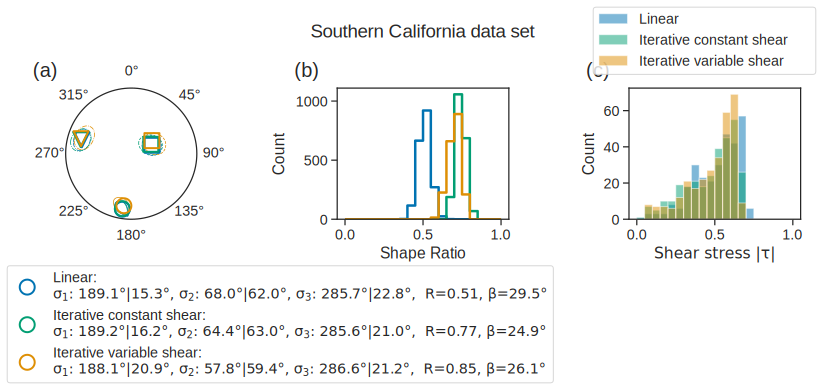

In [62]:
# plot results
kwargs = {}
kwargs["smoothing_sig"] = 5  # control the smoothness of the confidence intervals
kwargs["confidence_intervals"] = [95.0]
fig_SI = plot_inverted_stress_tensors(
    inversion_output, figtitle="Southern California data set", **kwargs
)


In [63]:
# save the figures
if save_figures:
   for fig in [fig_SI]:
      fig.savefig(f'{fig._label}.svg', format='svg')

In [64]:
def print_CI(inversion_output, CI_level=95.0, **kwargs):
    hist_kwargs = {}
    hist_kwargs["smoothing_sig"] = kwargs.get("smoothing_sig", 1)
    hist_kwargs["nbins"] = kwargs.get("nbins", 200)
    hist_kwargs["return_count"] = kwargs.get("return_count", True)
    hist_kwargs["confidence_intervals"] = [CI_level]
    methods = ["linear", "iterative_constant_shear", "iterative_variable_shear"]
    n_resamplings = inversion_output["linear"]["boot_principal_directions"].shape[0]
    for j in [0, 1, 2]:
        method = methods[j]
        print(f"---------- {method} ---------")
        R = ILSI.utils_stress.R_(inversion_output[method]["principal_stresses"])
        Rs = np.zeros(n_resamplings, dtype=np.float32)
        for b in range(n_resamplings):
            Rs[b] = ILSI.utils_stress.R_(
                inversion_output[method]["boot_principal_stresses"][b, :]
            )
        R_minus = np.percentile(Rs, (100.0 - CI_level) / 2.0)
        R_plus = np.percentile(Rs, CI_level + (100.0 - CI_level) / 2.0)
        print(
            f"\tShape ratio R = {R:.2f}, CI {CI_level:.0f} = ({R_minus:.2f}, {R_plus:.2f})"
        )
        for k in range(3):
            az, pl = ILSI.utils_stress.get_bearing_plunge(
                inversion_output[method]["principal_directions"][:, k]
            )
            boot_pd_stereo = np.zeros((n_resamplings, 2), dtype=np.float32)
            for b in range(n_resamplings):
                boot_pd_stereo[b, :] = ILSI.utils_stress.get_bearing_plunge(
                    inversion_output[method]["boot_principal_directions"][b, :, k]
                )
            count, lons_g, lats_g, levels = ILSI.utils_stress.get_CI_levels(
                boot_pd_stereo[:, 0], boot_pd_stereo[:, 1], **hist_kwargs
            )
            plunges, bearings = mpl.geographic2plunge_bearing(lons_g, lats_g)
            CR = np.where(count.flatten() >= levels[0])[0]
            CR_plunges = plunges.flatten()[CR]
            CR_bearings = bearings.flatten()[CR]
            print(f"\tPrincipal stress sigma {k+1}:")
            print(
                f"\t\tPlunge = {pl:.1f}"
                "\u00b0"
                f", CI {CI_level:.0f} = ({CR_plunges.min():.1f}"
                "\u00b0"
                f", {CR_plunges.max():.1f}"
                "\u00b0"
                f")"
            )
            print(
                f"\t\tBearing = {az:.1f}"
                "\u00b0"
                f", CI {CI_level:.0f} = ({CR_bearings.min():.1f}"
                "\u00b0"
                f", {CR_bearings.max():.1f}"
                "\u00b0"
                f")"
            )
            print(
                f"\t\t({az:.1f}"
                "\u00b0"
                f", {pl:.1f}"
                "\u00b0"
                f")  ({CR_bearings.min():.1f}"
                "\u00b0"
                f"-{CR_bearings.max():.1f}"
                "\u00b0"
                f", {CR_plunges.min():.1f}"
                "\u00b0"
                f"-{CR_plunges.max():.1f}"
                "\u00b0"
                f")"
            )


In [65]:
kwargs = {}
kwargs["smoothing_sig"] = 5  # control the smoothness of the confidence intervals
kwargs["confidence_intervals"] = [95.0]
print_CI(inversion_output, **kwargs)


---------- linear ---------
	Shape ratio R = 0.51, CI 95 = (0.43, 0.59)
	Principal stress sigma 1:
		Plunge = 15.3°, CI 95 = (5.3°, 26.7°)
		Bearing = 189.1°, CI 95 = (183.0°, 197.8°)
		(189.1°, 15.3°)  (183.0°-197.8°, 5.3°-26.7°)
	Principal stress sigma 2:
		Plunge = 62.0°, CI 95 = (50.2°, 74.4°)
		Bearing = 68.0°, CI 95 = (41.9°, 95.2°)
		(68.0°, 62.0°)  (41.9°-95.2°, 50.2°-74.4°)
	Principal stress sigma 3:
		Plunge = 22.8°, CI 95 = (10.8°, 34.5°)
		Bearing = 285.7°, CI 95 = (273.4°, 298.0°)
		(285.7°, 22.8°)  (273.4°-298.0°, 10.8°-34.5°)
---------- iterative_constant_shear ---------
	Shape ratio R = 0.77, CI 95 = (0.68, 0.81)
	Principal stress sigma 1:
		Plunge = 16.2°, CI 95 = (5.6°, 26.7°)
		Bearing = 189.2°, CI 95 = (183.1°, 197.5°)
		(189.2°, 16.2°)  (183.1°-197.5°, 5.6°-26.7°)
	Principal stress sigma 2:
		Plunge = 63.0°, CI 95 = (49.1°, 76.9°)
		Bearing = 64.4°, CI 95 = (31.0°, 93.0°)
		(64.4°, 63.0°)  (31.0°-93.0°, 49.1°-76.9°)
	Principal stress sigma 3:
		Plunge = 21.0°, CI 9

## Bonus: Uncertainty analysis beside bootstrapping: The resolution and posterior covariance operators

The previous figure shows bootstrapping uncertainties. Since the Tarantola-Valette inverse method uses the Bayesian framework, among the byproducts of the inversion are the posterior covariance operators $\hat{C}_D$ and $\hat{C}_M$. Furthermore, a generic concept to gauge the quality of an inverse method is the resolution operator $R$. Here, we simply demonstrate the tools implemented in `ILSI` to manipulate these operators. These concepts are discussed in detail in:
- Lundstern, Jens-Erik, Eric Beaucé, and Orlando J. Teran. "The importance of nodal plane orientation diversity for earthquake focal mechanism stress inversions." Geological Society, London (2024),

and also illustrated in:
- https://github.com/ebeauce/StressInversionResolution/

In general, bootstrapping will provide more realistic uncertainties but, in some cases where the input data set is small or relatively large but with little focal mechanism diversity, the posterior covariance and resolution operators may provide better uncertainties.

Note: The 5-element $m$ vector is $(\sigma_{11}, \sigma_{12}, \sigma_{13}, \sigma_{22}, \sigma_{23})$. We work in the (N=north, W=west, U=up) coordinate system, therefore $m$ is:<br>
$(\sigma_{NN}, \sigma_{NW}, \sigma_{NU}, \sigma_{WW}, \sigma_{WU})$

In [66]:
def plot_resolution_covariance_corrcoef(
    R,
    C_m_post,
    C_m_post_normalized,
    figname="resolution_covariance",
    figtitle=r"Resolution operator $R = LG$, posterior covariance $\hat{C}_M$"
             r" and normalized posterior covariance $\rho_M$",
    figsize=(13, 10),
    cmap="magma"
):
    """Plot resolution operator, posterior covariance, and normalized posterior covariance.

    Parameters:
    -----------
    R : array_like
        Resolution operator.
    C_m_post : array_like
        Posterior covariance.
    C_m_post_normalized : array_like
        Normalized posterior covariance.
    figname : str, optional
        Figure name (default is 'resolution_covariance').
    figtitle : str, optional
        Figure title (default is 'Resolution operator R = LG, posterior
        covariance C_M, and normalized posterior covariance ρ_M').
    figsize : tuple, optional
        Figure size (default is (13, 10)).
    cmap : str or Colormap, optional
        Colormap for plotting (default is 'viridis').
    """
    fig, axes = plt.subplots(num=figname, ncols=2, nrows=2, figsize=figsize)

    fig.suptitle(figtitle)
    plt.subplots_adjust(top=0.90, bottom=0.08, hspace=0.30)

    axes[0, 0].set_title(r"Resolution operator, $R = LG$")
    pc0 = axes[0, 0].pcolormesh(R, cmap=cmap, rasterized=True,)
    plt.colorbar(pc0, label="Resolution operator")

    diff = np.abs(np.identity(5) - R)
    axes[0, 1].set_title(r"$\vert I - R \vert$")
    pc1 = axes[0, 1].pcolormesh(diff, cmap=cmap, rasterized=True, vmin=0.,)
    plt.colorbar(pc1, label="Deviation from identity")

    axes[1, 0].set_title(r"Posterior covariance operator, $\hat{C}_M$")
    pc2 = axes[1, 0].pcolormesh(C_m_post, cmap=cmap, rasterized=True)
    plt.colorbar(pc2, label="Covariance")

    vmin = min(C_m_post_normalized[C_m_post_normalized < 0.999].min(), -C_m_post_normalized[C_m_post_normalized < 0.999].max())+0.01
    vmax = -vmin
    # vmin, vmax = -1., +1.
    cm = plt.cm.get_cmap("coolwarm")
    cm.set_over("w")

    axes[1, 1].set_title(r"Normalized post. covariance op., $\rho_M$")
    pc3 = axes[1, 1].pcolormesh(
            C_m_post_normalized, rasterized=True, vmin=vmin, vmax=vmax, cmap=cm
            )
    plt.colorbar(pc3, label="Normalized covariance")

    tickpos = [0.5, 1.5, 2.5, 3.5, 4.5]
    ticklabels = [
            r"$\sigma_{11}$",
            r"$\sigma_{12}$",
            r"$\sigma_{13}$",
            r"$\sigma_{22}$",
            r"$\sigma_{23}$"
            ]
    for i, ax in enumerate(axes.flatten()):
        ax.set_xlabel("True model parameter")
        ax.set_ylabel("Inverted model parameter")
        ax.set_xticks(tickpos)
        ax.set_xticklabels(ticklabels)
        ax.set_yticks(tickpos)
        ax.set_yticklabels(ticklabels)
        ax.text(
            -0.1,
            1.05,
            f"({string.ascii_lowercase[i]})",
            transform=ax.transAxes,
            size=20,
        )
    return fig


/tmp/ipykernel_47775/3902953570.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("coolwarm")


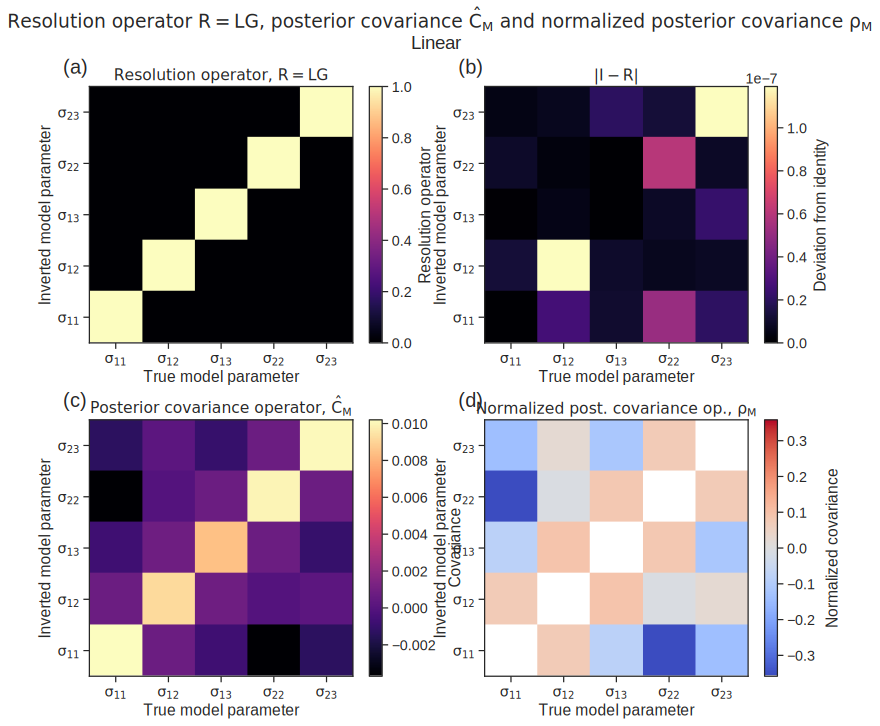

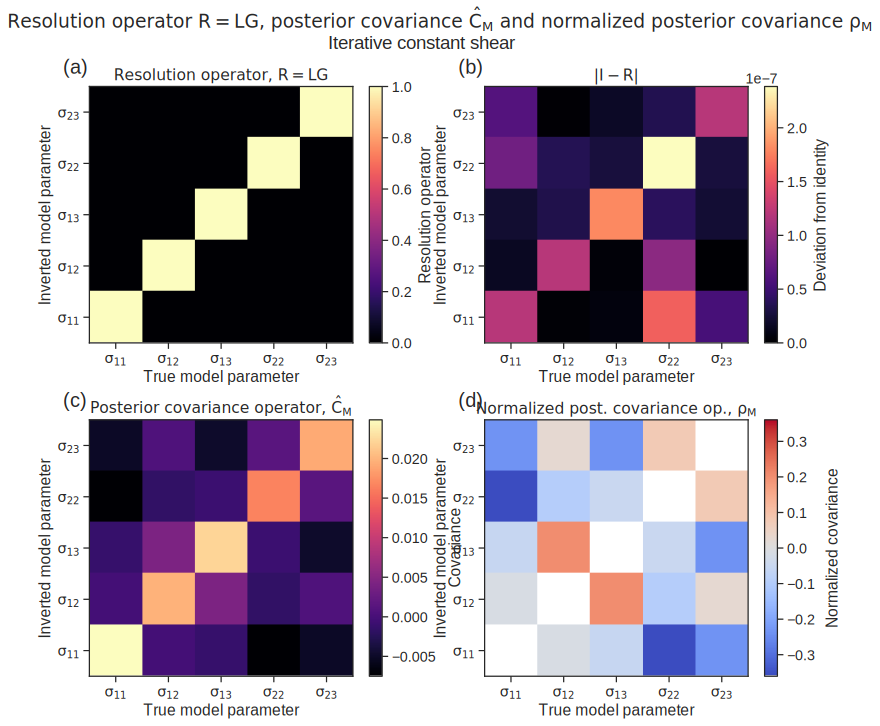

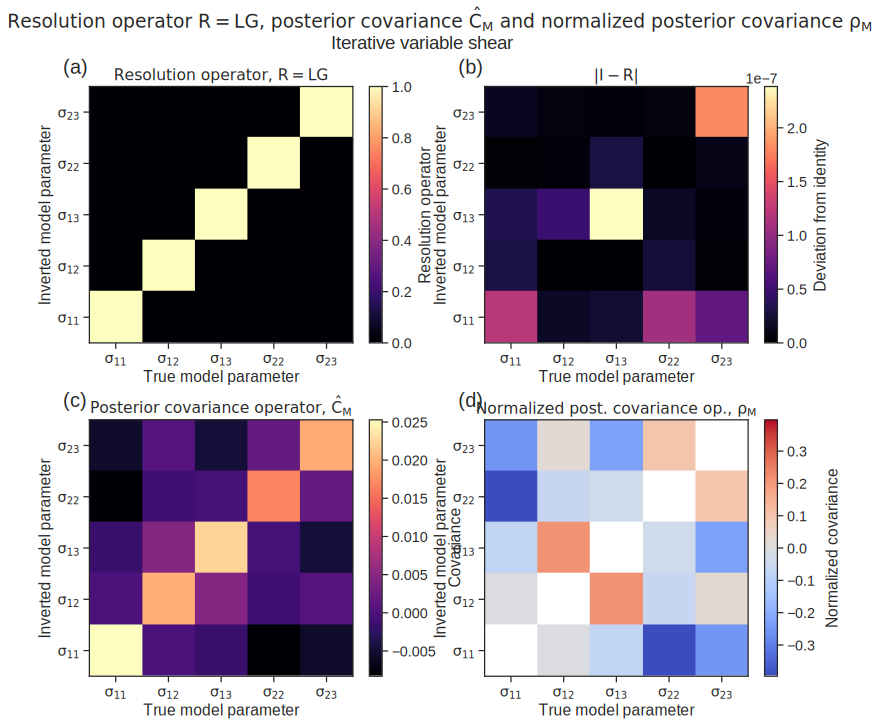

In [67]:
fig_resolutions = []
for method in ["linear", "iterative_constant_shear", "iterative_variable_shear"]:
    C_m_post = inversion_output[method]["C_m_posterior"]
    C_m_post_normalized = ( C_m_post / np.sqrt(np.diag(C_m_post))[:, None]) / (np.sqrt(np.diag(C_m_post))[None, :])
    fig_resolutions.append(plot_resolution_covariance_corrcoef(
        inversion_output[method]["resolution_operator"],
        inversion_output[method]["C_m_posterior"],
        C_m_post_normalized,
        figname=f"resolution_covariance_{method}",
    ))
    fig_resolutions[-1].suptitle(
        fig_resolutions[-1].texts[0].get_text() + f"\n{method.replace('_', ' ').capitalize()}", y=1.01
    )
    

## Some extra figures

In [68]:
def plot_Mohr(inversion, plot_density=False):
    import synthetic_dataset as syndata

    strikes = inversion["strikes"]
    dips = inversion["dips"]
    rakes = inversion["rakes"]
    fig, axes = plt.subplots(
        num=f"Mohr_space_Geysers", figsize=(15, 5), nrows=1, ncols=3
    )
    fig.suptitle(f"The Geysers geothermal field")
    for i, method in enumerate(
        ["linear", "iterative_constant_shear", "iterative_variable_shear"]
    ):
        axes[i].set_title(method.replace("_", " ").capitalize())
        st = inversion[method]["stress_tensor"]
        p_sig, p_dir = ILSI.utils_stress.stress_tensor_eigendecomposition(st)
        I, s, d, r = ILSI.ilsi.compute_instability_parameter(
            p_dir,
            ILSI.utils_stress.R_(p_sig),
            0.6,
            strikes[:, 0],
            dips[:, 0],
            rakes[:, 0],
            strikes[:, 1],
            dips[:, 1],
            rakes[:, 1],
            return_fault_planes=True,
        )
        fig = syndata.plot_dataset_Mohr(st, s, d, plot_density=plot_density, ax=axes[i])
        fig = syndata.plot_dataset_Mohr(st, s, d, plot_density=plot_density, ax=axes[i])
        fig = syndata.plot_dataset_Mohr(st, s, d, plot_density=plot_density, ax=axes[i])
    for i, ax in enumerate(axes.flatten()):
        ax.text(
            -0.1,
            1.05,
            f"({string.ascii_lowercase[i]})",
            transform=ax.transAxes,
            size=20,
        )
    fig.tight_layout()
    return fig


In [69]:
fig_Mohr = plot_Mohr(inversion_output, plot_density=True)

In [70]:
def plot_instabilities(inversion, mu=0.60, Imin=0.80):
    strikes = inversion["strikes"]
    dips = inversion["dips"]
    rakes = inversion["rakes"]
    fig, ax = plt.subplots(num="instabilities", figsize=(5, 5), nrows=1, ncols=1)
    for i, method in enumerate(
        ["linear", "iterative_constant_shear", "iterative_variable_shear"]
    ):
        stress_tensor = inversion[method]["stress_tensor"]
        p_sig, p_dir = ILSI.utils_stress.stress_tensor_eigendecomposition(stress_tensor)
        I, s, d, r = ILSI.ilsi.compute_instability_parameter(
            p_dir,
            ILSI.utils_stress.R_(p_sig),
            mu,
            strikes[:, 0],
            dips[:, 0],
            rakes[:, 0],
            strikes[:, 1],
            dips[:, 1],
            rakes[:, 1],
            return_fault_planes=True,
        )
        ax.hist(
            np.max(I, axis=-1),
            bins=20,
            range=(Imin, 1.0),
            color=_colors_[i],
            label=method.replace("_", " ").capitalize(),
            alpha=1,
            histtype="step",
            linewidth=3.0,
        )
    ax.set_xlabel(r"Instability $I$")
    ax.set_ylabel("Count")
    ax.legend(loc="upper left")
    return fig


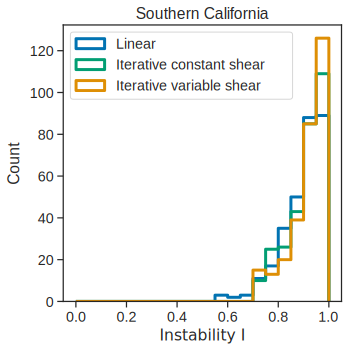

In [71]:
fig_inst = plot_instabilities(inversion_output, Imin = 0.)
ax = fig_inst.get_axes()[0]
ax.set_title('Southern California')
fig_inst.savefig(fig_inst._label+'_SoCal.svg', format='svg', bbox_inches='tight')